In [15]:
from figure_utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.style.use('./std-colors.mplstyle')
SAVE = True
all_df = pd.read_parquet(f"{RESULT_DIR}/daic/preprocessed.parquet")
all_df = all_df[~all_df.operator.isin(['Noop', 'Materialization'])]

gpu_mapping = {'2080': '2080Ti', '1080': '1080Ti', 'a40': 'A40', 'p100': 'P100', 'v100': 'V100'}
runtime_df = all_df[(all_df.dataset_type == 'synthetic')]

runtime_df.compute_unit = runtime_df.compute_unit.astype(str).apply(lambda x: gpu_mapping.get(x, x))
runtime_df['compute_unit'].unique()



array(['CPU 08c', 'CPU 32c', 'CPU 16c', '1080Ti', 'V100', 'P100', 'A40',
       '2080Ti'], dtype=object)

In [16]:
def round_partial (value, resolution):
    return round(round(value / resolution) * resolution, 2)

def add_red_line(ax, orientation, value=1.0,add_tick=False):
    hline_kwargs = dict(color='red', linestyle='dotted')
    if orientation == 'horizontal':
        if ax.get_ylim()[0] <= value <= ax.get_ylim()[1]:
            ax.axhline(value, **hline_kwargs)
            yticks = ax.get_yticks().tolist()
            idx = None
            if add_tick:
                if value not in yticks:
                    yticks.append(value)
                    ax.set_yticks(yticks)
                    idx=-1
                else:
                    idx = yticks.index(value)
            if idx:
                ax.get_yticklabels()[idx].set_color('red')
    elif orientation == 'vertical':
        if ax.get_xlim()[0] <= value <= ax.get_xlim()[1]:
            ax.axvline(value, **hline_kwargs)
            xticks = ax.get_xticks().tolist()
            idx = None
            if add_tick:
                if value not in xticks:
                    xticks.append(value)
                    ax.set_xticks(xticks)
                    idx=-1
                else:
                    idx = xticks.index(value)
            ax.get_xticklabels()[idx].set_color('red')
    else:
        raise ValueError("Invalid orientation. Choose either 'horizontal' or 'vertical'.")


## Benefit of Factorization

Show runtime saved by factorization

In [17]:
def format_dataset(dataset: str):
    dataset = dataset.split(":")[0]\
        .replace("usecase_01", "use-case\n1")\
        .replace("usecase_10", "use-case\n10")\
        .capitalize()
    return dataset
    
    
all_df['dataset_formatted'] = all_df['dataset'].apply(format_dataset)
all_df['mat_training_time'] = all_df.speedup * all_df['times_mean']
all_df['time_saved'] = all_df['mat_training_time'] - all_df['times_mean']

In [18]:
all_df[(all_df.operator.isin(MODEL_OPERATORS)) & (all_df.label) &( all_df.dataset_type != 'synthetic')].groupby("dataset_type")[['speedup', 'time_saved']].agg(['mean', 'std', 'max'])

speedup                      time_saved                     
                  mean       std        max       mean       std        max
dataset_type                                                               
hamlet        3.701748  3.770102  23.972204   1.866904  3.357827  24.255383
tpc_ai        7.400432  7.028462  27.357952   1.271206  1.216900   5.677513

In [19]:
all_df[(all_df.operator.isin(MODEL_OPERATORS)) & (all_df.label) &( all_df.dataset_type != 'synthetic')][['speedup', 'time_saved']].agg(['mean', 'std', 'max'])


,speedup,time_saved
mean,5.059422,1.648241
std,5.500652,2.784736
max,27.357952,24.255383


In [20]:
len(all_df[all_df.label]) / len(all_df)

0.18410873175086145

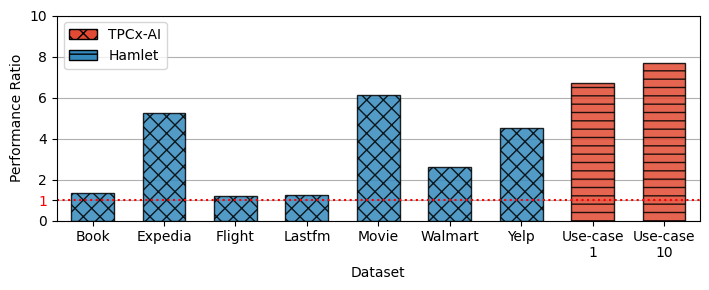

In [21]:

pos_label_real_df = all_df[(all_df.operator.isin(MODEL_OPERATORS)) & (all_df.label) &( all_df.dataset_type != 'synthetic')]

# Set the figure size
fig, ax = plt.subplots(figsize=(FIGURE_WIDTH_INCHES*0.9, 3))

# Create the bar plot
sns.barplot(data=pos_label_real_df, x='dataset_formatted', y='speedup', ax=ax, errorbar=None, width=0.6)
# Change the color of the last two bars
num_bars = len(ax.patches)

colors = sns.color_palette()
# Create a legend
legend_elements = [Patch(facecolor=colors[1], edgecolor='black', hatch='xx', label='TPCx-AI'),
                   Patch(facecolor=colors[0], edgecolor='black', hatch='--', label='Hamlet')]
ax.legend(handles=legend_elements)
for patch in ax.patches:
    patch.set_facecolor(colors[1] if patch.get_x() > 6 else colors[0])
    patch.set_alpha(0.85)
    # patch.set_facecolor('white')
    patch.set_edgecolor('black')
    patch.set_linewidth(1)
    patch.set_hatch('--' if patch.get_x() > 6 else 'xx')
    patch.set_capstyle('round')
    
add_red_line(ax, 'horizontal', 1.0, add_tick=True) 
# Add a horizontal grid
ax.grid(axis='y')
ax.set_axisbelow(True)
ax.set_ylabel("Performance Ratio")
ax.set_xlabel("Dataset")
fig.tight_layout()
if SAVE or True:
    fig.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/real_datasets_speedup.pdf", bbox_inches='tight')

## Data & Model Characteristics

Ideas
 - Complexity ratio vs performance ratio, broken down by X

In [22]:
runtime_df['complexity_rounded'] = runtime_df.complexity_ratio.apply(lambda x: round((x * 2), 0)/2)
runtime_df['TR_rounded'] = runtime_df.TR.apply(lambda x: round((x /4), 0)*2)
runtime_df['FR_rounded'] = runtime_df.FR.apply(lambda x: round((x *2), 0)/2)
runtime_df['speedup_rounded'] = runtime_df.speedup.apply(lambda x: round(x,1))

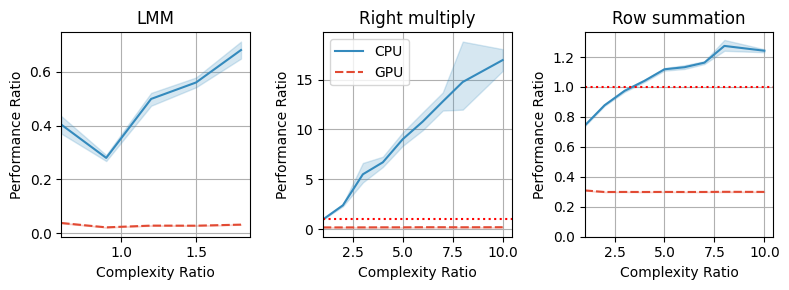

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(FIGURE_WIDTH_INCHES, 3))

for ax, round_res, (group, df) in zip(axs, [0.3, 1., 1.], runtime_df[runtime_df.operator.isin(['Row summation', 'LMM', 'Right multiply'])].groupby('operator')):
    df = df.copy()
    df.compute_type = df.compute_type.str.upper()
    
    df['complexity_rounded'] = df.complexity_ratio.apply(lambda x: round_partial(x, round_res))
    sns.lineplot(data=df, x='complexity_rounded', y='speedup', hue='compute_type', ax=ax, style='compute_type')
    
    ax.set_title(group)
    ax.grid()
    ax.set_ylabel("Performance Ratio")
    ax.set_xlabel("Complexity Ratio")
    
    ax.set_xlim(left=df.complexity_rounded.min())
    ax.set_axisbelow(True)
    if ax.get_ylim()[0] > 0.:
        ax.set_ylim(bottom=0.0)
    ax.get_legend().remove()
    if group == 'Right multiply':
        ax.legend()
    add_red_line(ax, 'horizontal')

    
fig.tight_layout()
if SAVE or False:
    fig.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/motivation_speedup_complexity_ratio.pdf", bbox_inches='tight')

In [24]:
runtime_df.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'compute_unit',
       'complexity_ratio', 'times_mean', 'source_file', 'dataset_type',
       'compute_type', 'label', 'features', 'parallelism', 'mem_mat_read',
       'mem_mat_write', 'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat',
       'comp_lmm_mat', 'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac',
       'comp_rmm_fac', 'comp_mat_col_major', 'comp_fac_col_major',
       'comp_scalar_dense', '13', '14', 'comp_matrix_dense',
       'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morp

## Hardware Characteristics

In [25]:
from io import StringIO


df = pd.read_csv("./tables/gpu-metrics/gpu-metrics.tsv", delimiter="\t", thousands=",")

df.fillna("", inplace=True)
df["characteristic"] = df.apply(
    lambda row: row["Group"].lower().replace(" ", "_") + "." + row["Characteristic"].lower().replace(" ", "_"), axis=1
).apply(lambda x: x[1:] if x.startswith(".") else x)
df.drop(columns=["Group", "Characteristic", "Unit"], inplace=True)
df = df.T
df.columns = df.tail(1).values[0]
df = df[:-1]
df.index.name = "GPU"
gpu_chars = pd.read_csv(StringIO(df.to_csv()), thousands=",")
gpu_chars.GPU = gpu_chars.GPU.astype(str)
gpu_chars

gpu_df = runtime_df.merge(gpu_chars, left_on="compute_unit", right_on="GPU")

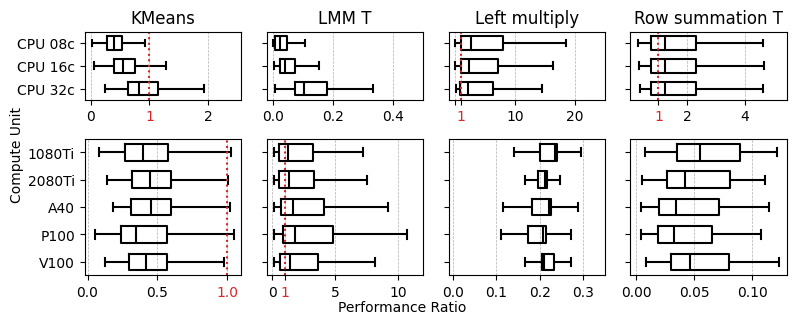

In [26]:
df = runtime_df[runtime_df.dataset_type == "synthetic"]
df = df[~df.operator.isin(["Noop", "Materialization"])]
operators = ["LMM T", "Left multiply", 'Row summation T', "KMeans"]
df.sort_values(by='compute_unit', ascending=True, inplace=True)

fig, axes = plt.subplots(2, len(operators), figsize=(FIGURE_WIDTH_INCHES, FIGURE_WIDTH_INCHES/2.5), sharex=False, sharey='row', gridspec_kw={'height_ratios': [1, 2]})

fig.text(0.5, 0.01, 'Performance Ratio', ha='center')
fig.text(0.01, 0.5, 'Compute Unit', va='center', rotation='vertical')

kwargs = dict(
    x="speedup",
    y="compute_unit",
    fill=False,
    fliersize=0,
    color="black",
    width=0.6,
)

for axs, (compute_type, sub_df) in zip(axes, df[df.operator.isin(operators)].groupby("compute_type")):        
    for ax, (operator, ssub_df) in zip(axs, sub_df.groupby("operator")):
        sns.boxplot(
            data=ssub_df,
            ax=ax,
            **kwargs
        )

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
        ax.axvline(1.0, linestyle='dotted', color='tab:red')
        ax.set_axisbelow(True)

        if compute_type == "cpu":
            ax.set_title(operator)
            
            if operator == "LMM T":
                ax.set_xlim((-0.02, 0.5))
                
            if operator == "Left multiply":
                ax.set_xlim((-1., 25))
                ax.set_xticks([0, 1, 10, 20])
                ax.set_xticklabels(['','1','10','20'])
                ax.get_xticklabels()[1].set_color('tab:red')
                
            if operator == "KMeans":
                ax.get_xticklabels()[2].set_color('tab:red')
                
            if operator == "Row summation T":
                ax.set_xticks([1, 2, 4])
                ax.get_xticklabels()[0].set_color('tab:red')
                
        if compute_type == "gpu":
            if operator == "Left multiply":
                ax.set_xticks([0.0, 0.1, 0.2, 0.3])
                ax.set_xlim(-0.01, 0.35)
        
            if operator == "KMeans": 
                ax.set_xlim(-0.02, 1.1)
                ax.get_xticklabels()[3].set_color('tab:red')
            
            if operator == "LMM T":
                ax.set_xticks([0, 1, 5, 10])
                ax.get_xticklabels()[1].set_color('tab:red')
            
            if operator == "Row summation T":
                ax.set_xlim(-0.005, 0.13)

plt.tight_layout()
if SAVE or False:
    fig.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/motivation_speedup_per_operator_per_gpu.pdf", bbox_inches="tight")

In [27]:
avg_speedup_df = df[(df.label & df.operator.isin(MODEL_OPERATORS))].groupby(["compute_unit"]).agg({"speedup": ["mean", "count", "std"]})
avg_speedup_df = avg_speedup_df.reindex(columns=[("speedup", "mean"), ("speedup", "std"), ("speedup", "count")]).speedup.reset_index()
avg_speedup_df['pct_with_speedup'] = (avg_speedup_df['count'] / 9660 * 100).apply(lambda x: f"{x:.2f}\%")
avg_speedup_df = avg_speedup_df.reindex(index=[3,4,5,0,1,2,6,7])
display(avg_speedup_df)
table = (
    avg_speedup_df.to_latex(float_format="%.2f", index=False)
    .replace("{lrrrl}", "{lrrrr}")
    .replace(" & \multicolumn{3}{r}{speedup} \\\n", "")
    .replace("mean", "Mean")
    .replace("std", "Std. Dev.")
    .replace("count", "Count")
    .replace("compute_unit", "Compute Unit")
    .replace("\midrule", "\midrule\midrule")
    .replace("pct_with_speedup", "\% with Speedup")
)
if SAVE or False:
    save_table(table, "chapters/05_cost_estimation/figures/speedup_per_gpu.tex")

,compute_unit,mean,std,count,pct_with_speedup
3,CPU 08c,1.268460,0.245277,172,1.78\%
4,CPU 16c,1.320765,0.344375,579,5.99\%
5,CPU 32c,1.476503,0.462475,2873,29.74\%
0,1080Ti,2.269407,1.599944,432,4.47\%
1,2080Ti,1.867994,1.090409,425,4.40\%
2,A40,2.004561,1.198363,392,4.06\%
6,P100,2.519784,1.836018,461,4.77\%
7,V100,1.945979,1.126639,404,4.18\%


\begin{tabular}{lrrrr}
\toprule
Compute Unit & Mean & Std. Dev. & Count & \% with Speedup \\
\midrule\midrule
CPU 08c & 1.27 & 0.25 & 172 & 1.78\% \\
CPU 16c & 1.32 & 0.34 & 579 & 5.99\% \\
CPU 32c & 1.48 & 0.46 & 2873 & 29.74\% \\
1080Ti & 2.27 & 1.60 & 432 & 4.47\% \\
2080Ti & 1.87 & 1.09 & 425 & 4.40\% \\
A40 & 2.00 & 1.20 & 392 & 4.06\% \\
P100 & 2.52 & 1.84 & 461 & 4.77\% \\
V100 & 1.95 & 1.13 & 404 & 4.18\% \\
\bottomrule
\end{tabular}



In [28]:
avg_speedup_df_operator = df[(df.operator.isin(["LMM T", "Left multiply", "Row summation T"])) & (df.compute_unit.isin(["V100", "P100"]))].groupby(["compute_unit", 'operator']).agg({"speedup": ["mean", "count", "std"]})
display(avg_speedup_df_operator.round(2))

speedup            
                                mean count   std
compute_unit operator                           
P100         LMM T              3.03  2415  2.70
             Left multiply      0.19  2415  0.05
             Row summation T    0.04  2415  0.03
V100         LMM T              2.33  2415  2.21
             Left multiply      0.21  2415  0.04
             Row summation T    0.05  2415  0.03